# Articulation points and bridges

In [11]:

import pandas as pd
import seaborn as sns

import config
from config import GRAPHS_PATH
from lib.graph_database_access import get_pathways
from lib.networks import get_interactomes, get_multiindex

% load_ext autoreload
% autoreload 2
% reload_ext autoreload

config.set_root_wd()

UsageError: Line magic function `%` not found.


## For each interactome

In [12]:
index = get_multiindex()
interactomes_no_sm, interactomes_with_sm, interactomes_with_unique_sm = get_interactomes(GRAPHS_PATH)
interactomes = [*interactomes_no_sm.values(), *interactomes_with_sm.values(), *interactomes_with_unique_sm.values()]

In [36]:
import decimal
from statistics import mean

columns = [
    "Number of Articulation Points",
    "Percentage articulation point nodes",
    "Number of accessioned entities articulation points",
    "Percentage of accessioned entities articulation points",
    "Number of small molecules articulation points",
    "Percentage of small molecules articulation points",
    "Number of interactions",
    "Number of bridge interactions",
    "Percentage of links that are bridges",
    "Percentage of links coming out of the accessioned entities that are bridges",
    "Percentage of links coming out of the small molecules that are bridges"
]


def count_accessioned_entites_art_points(g):
    return sum(g.nodes[n]["Articulation Point"] and not g.nodes[n]['type'].startswith("Simple") for n in g.nodes)


def count_small_molecules_art_points(g):
    return sum(g.nodes[n]["Articulation Point"] and g.nodes[n]['type'].startswith("Simple") for n in g.nodes)


def get_percentage_links_that_are_bridges(g, nodes):
    percentage_bridges_from_node = []
    for node in nodes:
        if len(g.edges(node)) > 0:
            num_bridges = sum(g.edges[e]['Bridge'] for e in g.edges(node))
            percentage_bridges_from_node.append(num_bridges / len(g.edges(node)))
        else:
            percentage_bridges_from_node.append(0)
    return mean(percentage_bridges_from_node)


def get_tuples(interactome):
    percentage_art_points = interactome.graph['Articulation Points'] / interactome.number_of_nodes()
    num_acc_ent_art_points = count_accessioned_entites_art_points(interactome)
    percentage_acc_ent_art_points = num_acc_ent_art_points / interactome.graph['num_entities']
    num_sm_art_points = count_small_molecules_art_points(interactome)
    percentage_sm_art_points = 0
    if interactome.graph['num_small_molecules'] > 0:
        percentage_sm_art_points = num_sm_art_points / interactome.graph['num_small_molecules']
    assert interactome.graph['Articulation Points'] == num_acc_ent_art_points + num_sm_art_points

    percentage_bridges = round(decimal.Decimal(interactome.graph["Bridges"]) / interactome.number_of_edges(), 5)
    acc_ents = list(interactome.nodes)
    percentage_from_sms = 0
    if interactome.graph['num_small_molecules'] > 0:
        acc_ents = [n for n in interactome.nodes if not interactome.nodes[n]['type'].startswith("Simple")]
        sms = [n for n in interactome.nodes if interactome.nodes[n]['type'].startswith("Simple")]
        percentage_from_sms = get_percentage_links_that_are_bridges(interactome, sms)
    percentage_from_acc_ents = get_percentage_links_that_are_bridges(interactome, acc_ents)

    return (
        interactome.graph['Articulation Points'],
        percentage_art_points,
        num_acc_ent_art_points,
        percentage_acc_ent_art_points,
        num_sm_art_points,
        percentage_sm_art_points,
        interactome.number_of_edges(),
        interactome.graph["Bridges"],
        percentage_bridges,
        percentage_from_acc_ents,
        percentage_from_sms
    )


df_br_ap = pd.DataFrame([get_tuples(interactome) for interactome in interactomes],
                        columns=columns,
                        index=index)
df_br_ap

Number of Articulation Points  \
Small Molecules          Entity Level                                  
Not Included             genes                                   269   
                         proteins                                270   
                         proteoforms                             349   
Included                 genes                                   246   
                         proteins                                246   
                         proteoforms                             255   
Reaction-Unique Included genes                                  1889   
                         proteins                               1888   
                         proteoforms                            1919   

                                       Percentage of nodes that are articulation points  \
Small Molecules          Entity Level                                                     
Not Included             genes                                                     0.02   
                         proteins                                                  0.02   
                         proteoforms                                               0.02   
Included                 genes                                                     0.02   
                         proteins                                                  0.02   
                         proteoforms                                               0.02   
Reaction-Unique Included genes                                                     0.05   
                         proteins                                                  0.05   
                         proteoforms                                               0.05   

                                       Number of accessioned entities that are articulation points  \
Small Molecules          Entity Level                                                                
Not Included             genes                                                       269             
                         proteins                                                    270             
                         proteoforms                                                 349             
Included                 genes                                                       145             
                         proteins                                                    145             
                         proteoforms                                                 153             
Reaction-Unique Included genes                                                      1486             
                         proteins                                                   1485             
                         proteoforms                                                1516             

                                       Percentage of accessioned entities that are articulation points  \
Small Molecules          Entity Level                                                                    
Not Included             genes                                                      0.02                 
                         proteins                                                   0.02                 
                         proteoforms                                                0.02                 
Included                 genes                                                      0.01                 
                         proteins                                                   0.01                 
                         proteoforms                                                0.01                 
Reaction-Unique Included genes                                                      0.14                 
                         proteins                                                   0.13                 
                         proteoforms                         

In [37]:
data = {
    "Bottleneck": ["Articulation Points"] * 9,
    "Percentage": df_br_ap["Percentage articulation point nodes"]
}
df_art_points = pd.DataFrame(data)
df_art_points.reset_index(inplace=True)

data = {
    "Bottleneck": ["Bridges"] * 9,
    "Percentage": df_br_ap["Percentage of links that are bridges"]
}
df_bridges = pd.DataFrame(data)
df_bridges.reset_index(inplace=True)

data_br_ap = pd.concat([df_art_points, df_bridges])
data_br_ap

,Small Molecules,Entity Level,Bottleneck,Percentage
0,Not Included,genes,Articulation Points,0.02
1,Not Included,proteins,Articulation Points,0.02
2,Not Included,proteoforms,Articulation Points,0.02
3,Included,genes,Articulation Points,0.02
4,Included,proteins,Articulation Points,0.02
5,Included,proteoforms,Articulation Points,0.02
6,Reaction-Unique Included,genes,Articulation Points,0.05
7,Reaction-Unique Included,proteins,Articulation Points,0.05
8,Reaction-Unique Included,proteoforms,Articulation Points,0.05
0,Not Included,genes,Bridges,0.00114


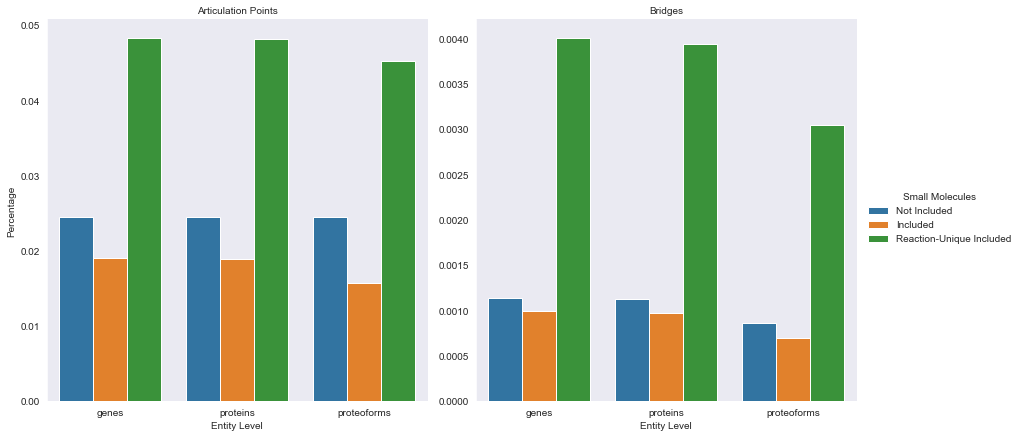

In [38]:
sns.set_style("dark")
f = sns.catplot(x="Entity Level",
                y="Percentage",
                hue="Small Molecules",
                col="Bottleneck",
                data=data_br_ap,
                kind="bar",
                height=6, aspect=1, sharey=False)
f.set_titles("{col_name}")

## For each pathway

In [39]:
from lib.networks import create_pathway_interaction_network
from config import LEVELS, METHODS

# Create all pathway networks
# Sets each node as node as articulation points or not
# Sets each edge as bridge or not
df_pathways = get_pathways()
#for pathway in df_pathways["stId"]:
#    create_pathway_interaction_networks(pathway, "resources/pathway_networks/")
df_pathways

,stId,displayName
0,R-HSA-9613829,Chaperone Mediated Autophagy
1,R-HSA-1632852,Macroautophagy
2,R-HSA-5205685,PINK1-PRKN Mediated Mitophagy
3,R-HSA-8934903,Receptor Mediated Mitophagy
4,R-HSA-9613354,Lipophagy
...,...,...
2060,R-HSA-432722,Golgi Associated Vesicle Biogenesis
2061,R-HSA-432720,Lysosome Vesicle Biogenesis
2062,R-HSA-8856828,Clathrin-mediated endocytosis
2063,R-HSA-8856825,Cargo recognition for clathrin-mediated endocy...


In [40]:
def get_combinations():
    combinations = []
    for method in METHODS:
        for level in LEVELS:
            for pathway in df_pathways["stId"][:100]:
                combinations.append((method, level, pathway))
    return combinations


combinations = get_combinations()
combinations[0:30]

[('no_sm', 'genes', 'R-HSA-9613829'),
 ('no_sm', 'genes', 'R-HSA-1632852'),
 ('no_sm', 'genes', 'R-HSA-5205685'),
 ('no_sm', 'genes', 'R-HSA-8934903'),
 ('no_sm', 'genes', 'R-HSA-9613354'),
 ('no_sm', 'genes', 'R-HSA-9664873'),
 ('no_sm', 'genes', 'R-HSA-9646399'),
 ('no_sm', 'genes', 'R-HSA-9615710'),
 ('no_sm', 'genes', 'R-HSA-141444'),
 ('no_sm', 'genes', 'R-HSA-141405'),
 ('no_sm', 'genes', 'R-HSA-141430'),
 ('no_sm', 'genes', 'R-HSA-69481'),
 ('no_sm', 'genes', 'R-HSA-69473'),
 ('no_sm', 'genes', 'R-HSA-174437'),
 ('no_sm', 'genes', 'R-HSA-75035'),
 ('no_sm', 'genes', 'R-HSA-888593'),
 ('no_sm', 'genes', 'R-HSA-888568'),
 ('no_sm', 'genes', 'R-HSA-110056'),
 ('no_sm', 'genes', 'R-HSA-112411'),
 ('no_sm', 'genes', 'R-HSA-112409'),
 ('no_sm', 'genes', 'R-HSA-69478'),
 ('no_sm', 'genes', 'R-HSA-176187'),
 ('no_sm', 'genes', 'R-HSA-68911'),
 ('no_sm', 'genes', 'R-HSA-2468052'),
 ('no_sm', 'genes', 'R-HSA-69895'),
 ('no_sm', 'genes', 'R-HSA-349425'),
 ('no_sm', 'genes', 'R-HSA-69541'),

In [108]:
columns = [
    "Small Molecules", "Entity Level", "Pathway",
    "Number of nodes", "Number of articulation point nodes", "Percentage of articulation point nodes",
    "Number of accessioned entities articulation points", "Percentage of accessioned entities articulation points",
    "Number of small molecule articulation points", "Percentage of small molecules that are articulation points",

    "Number of links", "Number of links bridges", "Percentage of bridge links",
    "Percentage of bridge links from accessioned entities",
    "Percentage of bridge links from small molecules"
]

out_path = "resources/pathway_networks/"


def get_tuples(combination):
    G = create_pathway_interaction_network(
        method=combination[0], level=combination[1], pathway=combination[2], out_path=out_path
    )

    percentage_art_points = G.graph['Articulation Points'] / G.number_of_nodes()
    num_acc_ent_art_points = count_accessioned_entites_art_points(G)
    percentage_acc_ent_art_points = num_acc_ent_art_points / G.graph['num_entities']
    num_sm_art_points = count_small_molecules_art_points(G)
    percentage_sm_art_points = 0
    if G.graph['num_small_molecules'] > 0:
        percentage_sm_art_points = num_sm_art_points / G.graph['num_small_molecules']
    assert G.graph['Articulation Points'] == num_acc_ent_art_points + num_sm_art_points

    percentage_bridges = 0
    if G.number_of_edges() > 0:
        percentage_bridges = round(decimal.Decimal(G.graph["Bridges"]) / G.number_of_edges(), 5)
    acc_ents = list(G.nodes)
    percentage_from_sms = 0
    if G.graph['num_small_molecules'] > 0:
        acc_ents = [n for n in G.nodes if not G.nodes[n]['type'].startswith("Simple")]
        sms = [n for n in G.nodes if G.nodes[n]['type'].startswith("Simple")]
        percentage_from_sms = get_percentage_links_that_are_bridges(G, sms)
    percentage_from_acc_ents = get_percentage_links_that_are_bridges(G, acc_ents)

    return (
        combination[0], combination[1], combination[2],
        G.number_of_nodes(), G.graph['Articulation Points'], percentage_art_points,
        num_acc_ent_art_points, percentage_acc_ent_art_points,
        num_sm_art_points, percentage_sm_art_points,

        G.number_of_edges(), G.graph["Bridges"], float(percentage_bridges),
        percentage_from_acc_ents,
        percentage_from_sms
    )

In [109]:
df_br_ap_pathways = pd.DataFrame([get_tuples(combination) for combination in combinations], columns=columns)
df_br_ap_pathways

,Small Molecules,Entity Level,Pathway,Number of nodes,Number of articulation point nodes,Percentage of articulation point nodes,Number of accessioned entities articulation points,Percentage of accessioned entities articulation points,Number of small molecule articulation points,Percentage of small molecules that are articulation points,Number of links,Number of links bridges,Percentage of bridge links,Percentage of bridge links from accessioned entities,Percentage of bridge links from small molecules
0,no_sm,genes,R-HSA-9613829,21,1,0.05,1,0.05,0,0.00,188,1,0.01,0.05,0.00
1,no_sm,genes,R-HSA-1632852,114,3,0.03,3,0.03,0,0.00,959,1,0.00,0.01,0.00
2,no_sm,genes,R-HSA-5205685,22,1,0.05,1,0.05,0,0.00,89,0,0.00,0.00,0.00
3,no_sm,genes,R-HSA-8934903,11,1,0.09,1,0.09,0,0.00,19,3,0.16,0.30,0.00
4,no_sm,genes,R-HSA-9613354,9,0,0.00,0,0.00,0,0.00,36,0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,with_unique_sm,proteoforms,R-HSA-5684264,30,1,0.03,1,0.05,0,0.00,125,0,0.00,0.00,0.00
896,with_unique_sm,proteoforms,R-HSA-2562578,17,0,0.00,0,0.00,0,0.00,93,0,0.00,0.00,0.00
897,with_unique_sm,proteoforms,R-HSA-936964,42,0,0.00,0,0.00,0,0.00,330,0,0.00,0.00,0.00
898,with_unique_sm,proteoforms,R-HSA-937041,32,0,0.00,0,0.00,0,0.00,194,0,0.00,0.00,0.00


In [110]:
df_br_ap_pathways.dtypes

Small Molecules                                                object
Entity Level                                                   object
Pathway                                                        object
Number of nodes                                                 int64
Number of articulation point nodes                              int64
Percentage of articulation point nodes                        float64
Number of accessioned entities articulation points              int64
Percentage of accessioned entities articulation points        float64
Number of small molecule articulation points                    int64
Percentage of small molecules that are articulation points    float64
Number of links                                                 int64
Number of links bridges                                         int64
Percentage of bridge links                                    float64
Percentage of bridge links from accessioned entities          float64
Percentage of bridge

In [111]:
df_pathways_grouped = df_br_ap_pathways.groupby(['Small Molecules', 'Entity Level']).agg(
    {
        "Number of nodes": ['mean'],
        "Number of articulation point nodes": ['mean'],
        "Percentage of articulation point nodes": ['mean'],
        "Number of accessioned entities articulation points": ['mean'],
        "Percentage of accessioned entities articulation points": ['mean'],
        "Number of small molecule articulation points": ['mean'],
        "Percentage of small molecules that are articulation points": ['mean'],
        "Number of links": ['mean'],
        "Number of links bridges": ['mean'],
        "Percentage of bridge links": ['mean']
    })
df_pathways_grouped.columns = [
    "Number of nodes", "Number of articulation point nodes", "Percentage of articulation point nodes",
    "Number of accessioned entities articulation points", "Percentage of accessioned entities articulation points",
    "Number of small molecule articulation points", "Percentage of small molecules that are articulation points",
    "Number of links", "Number of links bridges", "Percentage of bridge links"
]
df_pathways_grouped = df_pathways_grouped.set_index(get_multiindex())

df_pathways_grouped

Number of nodes  \
Small Molecules          Entity Level                    
Not Included             genes                   35.60   
                         proteins                35.60   
                         proteoforms             39.10   
Included                 genes                   38.27   
                         proteins                38.27   
                         proteoforms             41.77   
Reaction-Unique Included genes                   42.29   
                         proteins                42.29   
                         proteoforms             45.79   

                                       Number of articulation point nodes  \
Small Molecules          Entity Level                                       
Not Included             genes                                       0.74   
                         proteins                                    0.74   
                         proteoforms                                 1.10   
Included                 genes                                       0.61   
                         proteins                                    0.61   
                         proteoforms                                 0.69   
Reaction-Unique Included genes                                       0.92   
                         proteins                                    0.92   
                         proteoforms                                 0.97   

                                       Percentage of articulation point nodes  \
Small Molecules          Entity Level                                           
Not Included             genes                                           0.04   
                         proteins                                        0.04   
                         proteoforms                                     0.05   
Included                 genes                                           0.02   
                         proteins                                        0.02   
                         proteoforms                                     0.02   
Reaction-Unique Included genes                                           0.03   
                         proteins                                        0.03   
                         proteoforms                                     0.03   

                                       Number of accessioned entities articulation points  \
Small Molecules          Entity Level                                                       
Not Included             genes                                                      0.74    
                         proteins                                                   0.74    
                         proteoforms                                                1.10    
Included                 genes                                                      0.52    
                         proteins                                                   0.52    
                         proteoforms                                                0.60    
Reaction-Unique Included genes                                                      0.82    
                         proteins                                                   0.82    
                         proteoforms                                                0.87    

                                       Percentage of accessioned entities articulation points  \
Small Molecules          Entity Level                                                           
Not Included             genes                                                      0.04        
                         proteins                                                   0.04        
                         proteoforms                                                0.05        
Included                 genes                                                      0.02        
                         proteins                     

In [98]:
df_pathways_grouped = df_br_ap_pathways.apply().groupby(
    ['Small Molecules', 'Entity Level']
).agg(
    {
        "Number of nodes": ['mean'],
        "Number of articulation point nodes": ['mean'],
        "Percentage of articulation point nodes": ['mean'],
        "Number of accessioned entities articulation points": ['mean'],
        "Percentage of accessioned entities articulation points": ['mean'],
        "Number of small molecule articulation points": ['mean'],
        "Percentage of small molecules that are articulation points": ['mean'],
        "Number of links": ['mean'],
        "Number of links bridges": ['mean'],
        "Percentage of bridge links": ['mean'],
        "Percentage of bridge links from accessioned entities": ['mean'],
        "Percentage of bridge links from small molecules": ['mean']
    })
df_pathways_grouped.columns = [
    "Number of nodes", "Number of articulation point nodes", "Percentage of articulation point nodes",
    "Number of accessioned entities articulation points", "Percentage of accessioned entities articulation points",
    "Number of small molecule articulation points", "Percentage of small molecules that are articulation points",
    "Number of links", "Number of links bridges", "Percentage of bridge links",
    "Percentage of bridge links from accessioned entities",
    "Percentage of bridge links from small molecules"
]
df_pathways_grouped = df_pathways_grouped.set_index(get_multiindex())

df_pathways_grouped

TypeError: to_numeric() missing 1 required positional argument: 'arg'

Text(0.5, 1.0, 'Percentage of articulation point nodes in Pathways')

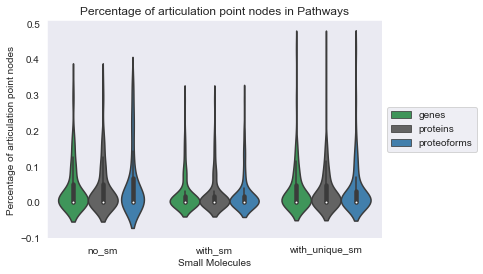

In [76]:
f = sns.violinplot(x="Small Molecules", y="Percentage of articulation point nodes", hue="Entity Level",
                   data=df_br_ap_pathways, palette=config.COLORS_BORDER)
#ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$")) # Convert ticks to powers of 10
f.legend(loc='center left', bbox_to_anchor=(1, 0.5))
f.set_title("Percentage of articulation point nodes in Pathways")

Text(0.5, 1.0, 'Percentage of bridge links in Pathways')

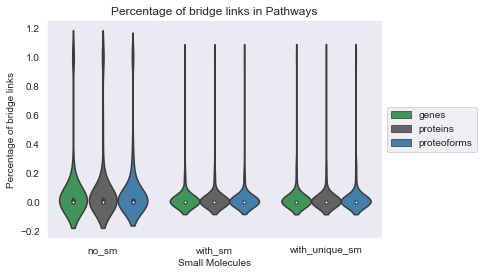

In [80]:
df_br_ap_pathways["Percentage of bridge links"] = df_br_ap_pathways["Percentage of bridge links"].astype('float64')
f2 = sns.violinplot(x="Small Molecules", y="Percentage of bridge links", hue="Entity Level",
                    data=df_br_ap_pathways, palette=config.COLORS_BORDER)
f2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
f2.set_title("Percentage of bridge links in Pathways")

In [81]:
data = {
    "Bottleneck": ["Articulation Points"] * len(df_br_ap_pathways),
    "Small Molecules": df_br_ap_pathways["Small Molecules"],
    "Entity Level": df_br_ap_pathways["Entity Level"],
    "Pathway": df_br_ap_pathways["Pathway"],
    "Percentage": df_br_ap_pathways["Percentage of articulation point nodes"]
}
df_art_points = pd.DataFrame(data)
df_art_points

,Bottleneck,Small Molecules,Entity Level,Pathway,Percentage
0,Articulation Points,no_sm,genes,R-HSA-9613829,0.05
1,Articulation Points,no_sm,genes,R-HSA-1632852,0.03
2,Articulation Points,no_sm,genes,R-HSA-5205685,0.05
3,Articulation Points,no_sm,genes,R-HSA-8934903,0.09
4,Articulation Points,no_sm,genes,R-HSA-9613354,0.00
...,...,...,...,...,...
895,Articulation Points,with_unique_sm,proteoforms,R-HSA-5684264,0.03
896,Articulation Points,with_unique_sm,proteoforms,R-HSA-2562578,0.00
897,Articulation Points,with_unique_sm,proteoforms,R-HSA-936964,0.00
898,Articulation Points,with_unique_sm,proteoforms,R-HSA-937041,0.00


In [82]:
data = {
    "Bottleneck": ["Bridges"] * len(df_br_ap_pathways),
    "Small Molecules": df_br_ap_pathways["Small Molecules"],
    "Entity Level": df_br_ap_pathways["Entity Level"],
    "Pathway": df_br_ap_pathways["Pathway"],
    "Percentage": df_br_ap_pathways["Percentage of bridge links"]
}
df_bridges = pd.DataFrame(data)
df_bridges

,Bottleneck,Small Molecules,Entity Level,Pathway,Percentage
0,Bridges,no_sm,genes,R-HSA-9613829,0.01
1,Bridges,no_sm,genes,R-HSA-1632852,0.00
2,Bridges,no_sm,genes,R-HSA-5205685,0.00
3,Bridges,no_sm,genes,R-HSA-8934903,0.16
4,Bridges,no_sm,genes,R-HSA-9613354,0.00
...,...,...,...,...,...
895,Bridges,with_unique_sm,proteoforms,R-HSA-5684264,0.00
896,Bridges,with_unique_sm,proteoforms,R-HSA-2562578,0.00
897,Bridges,with_unique_sm,proteoforms,R-HSA-936964,0.00
898,Bridges,with_unique_sm,proteoforms,R-HSA-937041,0.00


In [83]:
data_br_ap = pd.concat([df_art_points, df_bridges])
data_br_ap

,Bottleneck,Small Molecules,Entity Level,Pathway,Percentage
0,Articulation Points,no_sm,genes,R-HSA-9613829,0.05
1,Articulation Points,no_sm,genes,R-HSA-1632852,0.03
2,Articulation Points,no_sm,genes,R-HSA-5205685,0.05
3,Articulation Points,no_sm,genes,R-HSA-8934903,0.09
4,Articulation Points,no_sm,genes,R-HSA-9613354,0.00
...,...,...,...,...,...
895,Bridges,with_unique_sm,proteoforms,R-HSA-5684264,0.00
896,Bridges,with_unique_sm,proteoforms,R-HSA-2562578,0.00
897,Bridges,with_unique_sm,proteoforms,R-HSA-936964,0.00
898,Bridges,with_unique_sm,proteoforms,R-HSA-937041,0.00


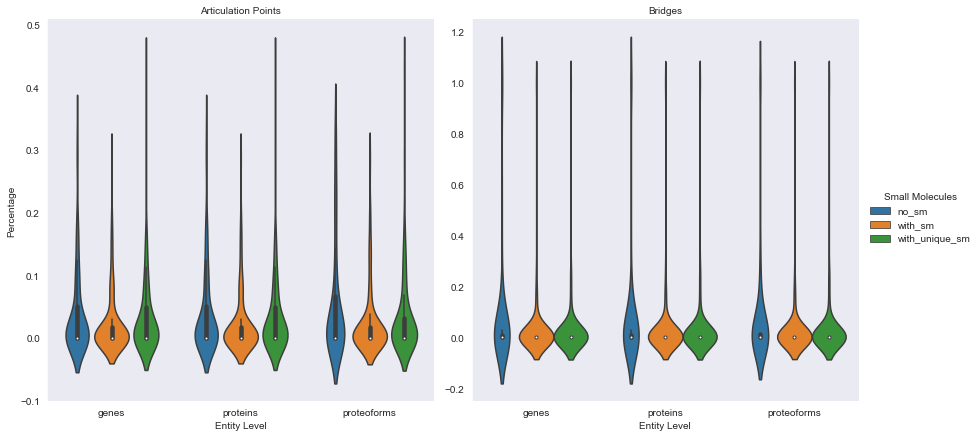

In [84]:
sns.set_style("dark")
f = sns.catplot(x="Entity Level",
                y="Percentage",
                hue="Small Molecules",
                col="Bottleneck",
                data=data_br_ap,
                kind="violin",
                height=6, aspect=1, sharey=False)
f.set_titles("{col_name}")
